# Urbanization <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)


## Background
This notebook addressess the calculation of land consumption rate (urbanization) using **Normalized Differential Built Index (NDBI)** and  **Normalized Differential Vegetation Index (NDVI)**.


## Description
This notebook demonstrates how to:

1. Calculate urbanization index from NDBI and NDVI

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.  

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import numpy as np
import matplotlib.pyplot as plt
from odc.ui import with_ui_cbk
from odc.algo import to_f32, from_float, xr_geomedian

import sys
sys.path.append('../Scripts')

from deafrica_datahandling import load_ard, mostcommon_crs
from deafrica_plotting import display_map, rgb
from deafrica_bandindices import calculate_indices
from deafrica_dask import create_local_dask_cluster

## Load Landsat 8 data from the datacube

Here we are loading in a timeseries of `Landsat 8` satellite images through the datacube API.
This will provide us with some data to work with.

In [2]:
dc = datacube.Datacube(app='DEA_urbanization')

In [3]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:43331 Dashboard: /user/nanaboamah/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


In [4]:
lat, lon = 6.6724, -1.6070
buffer = 0.1

# Create a reusable query
query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
#     'time': ('2016-01', '2017-12'),
    'group_by': 'solar_day',
    'resolution': (-30, 30),
    'align': (15, 15)
#     'measurements': ['*']
}

In [5]:
#Display area of interest
display_map(query['x'], query['y'], zoom_bias = 1)

In [6]:
output_crs = mostcommon_crs(dc=dc, product='ls8_usgs_sr_scene', query=query)

In [7]:
def compute_ds(query, output_crs):
    try:
        ds = load_ard(dc=dc, 
              products=['ls8_usgs_sr_scene'],
              output_crs=output_crs,
              progress_cbk= with_ui_cbk(),
              dask_chunks={'time': 1, 'x': 500, 'y': 500},
              **query)
        return ds
    except ValueError:
        print('No Data Available')
    
    

In [8]:
query['time'] = ('2014')
ds_2014 = compute_ds(query, output_crs)

# query['time'] = ('2018')
# ds_2018 = compute_ds(query, output_crs)

query['time'] = ('2019')
ds_2019 = compute_ds(query, output_crs)

# query['time'] = ('2020')
# ds_2020 = compute_ds(query, output_crs)

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Returning 11 time steps as a dask array


Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Returning 9 time steps as a dask array


In [9]:
#col='time'
#rgb(ds_2020, col="time")
#rgb(ds, index=list(range(0, 4)))

In [10]:
sr_max_value = 10000                 # maximum value for SR in the loaded product
scale, offset = (1/sr_max_value, 0)  # differs per product, aim for 0-1 values in float32

In [11]:
def generate_geomedian(ds_dataset):
    
    #scale the values using the f_32 util function
    ds_scaled = to_f32(ds_dataset, scale=scale, offset=offset)

    #generate a geomedian
    ds_geomedian = xr_geomedian(ds_scaled, 
                         num_threads=1,  # disable internal threading, dask will run several concurrently
                         eps=1e-7,  
                         nocheck=True)   # disable checks inside library that use too much ram
    #convert SR scaling values back to original values
    ds_geomedian = from_float(ds_geomedian, 
                           dtype='float32', 
                           nodata=np.nan, 
                           scale=1/scale, 
                           offset=-offset/scale)
   
    ds_geomedian = ds_geomedian.compute()

    return ds_geomedian



In [12]:
%%time
ds_2014_geomedian = generate_geomedian(ds_2014)
ds_2019_geomedian = generate_geomedian(ds_2019)

CPU times: user 3.83 s, sys: 411 ms, total: 4.24 s
Wall time: 1min 21s


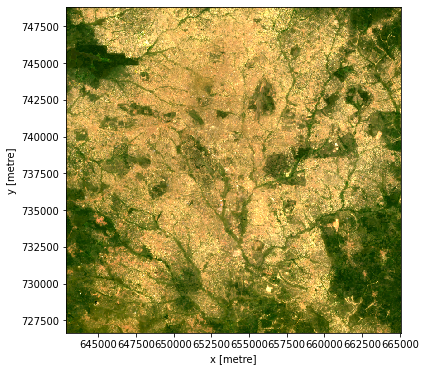

In [13]:
rgb(ds_2014_geomedian)

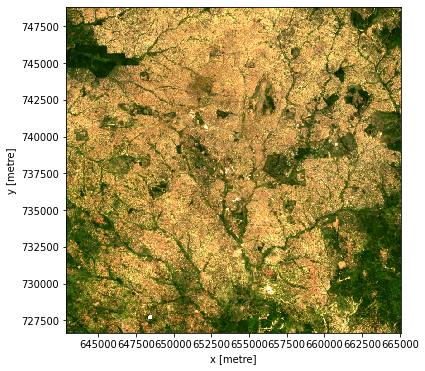

In [14]:
rgb(ds_2019_geomedian)

In [15]:
# Calculate NDVI and NDBI using the formula above
ds_2014_geomedian = calculate_indices(ds_2014_geomedian, index=['NDVI', 'NDBI', 'BUI', 'BSI'], collection = 'c1')
ds_2019_geomedian = calculate_indices(ds_2019_geomedian, index=['NDVI', 'NDBI', 'BUI', 'BSI'], collection = 'c1')

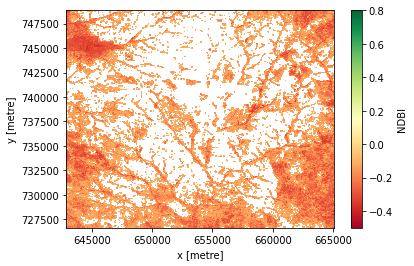

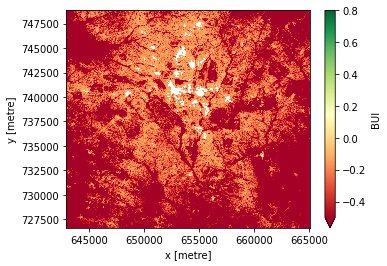

In [16]:
# Plot the results for one time step to see what they look like:
# ds_indices.NDVI.isel(time=0).plot(vmin=-0.50, vmax=0.8, cmap='RdYlGn')
ds_2014_geomedian.NDBI.where(ds_2014_geomedian.NDBI < -0.1).plot(vmin=-0.50, vmax=0.8, cmap='RdYlGn')
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(121)
ds_2014_geomedian.BUI.where(ds_2014_geomedian.BUI < -0.1).plot(vmin=-0.50, vmax=0.8, cmap='RdYlGn')

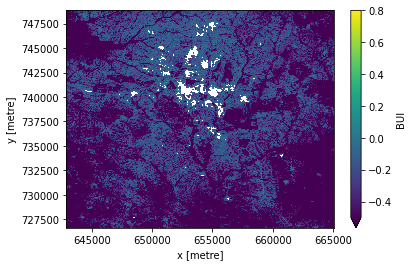

In [17]:
ds_2019_geomedian.BUI.where(ds_2014_geomedian.BUI < -0.1).plot(vmin=-0.50, vmax=0.8, cmap='viridis')

In [18]:
ds_2014_geomedian['built_index'] = ds_2014_geomedian.BUI - ds_2014_geomedian.NDVI
ds_2019_geomedian['built_index'] = ds_2019_geomedian.BUI - ds_2019_geomedian.NDVI

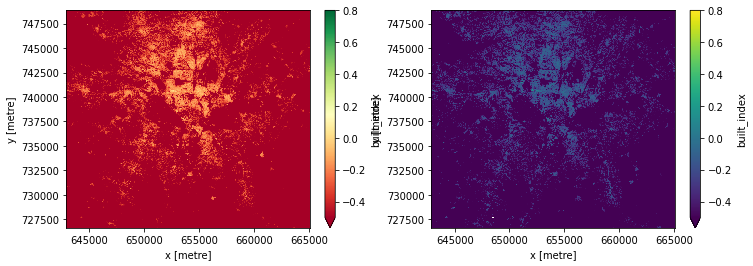

In [19]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(121)
ds_2014_geomedian.built_index.plot(vmin=-0.50, vmax=0.8, cmap='RdYlGn')
fig.add_subplot(122)
ds_2019_geomedian.built_index.plot(vmin=-0.50, vmax=0.8, cmap='viridis')

In [20]:
#filter to get only the 
ds_2014_urban_area = ds_2014_geomedian.where(ds_2014_geomedian.built_index < -0.1)
ds_2019_urban_area = ds_2019_geomedian.where(ds_2019_geomedian.built_index < -0.1)

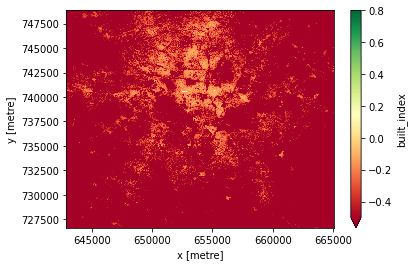

In [21]:
ds_2014_urban_area.built_index.plot(vmin=-0.50, vmax=0.8, cmap='RdYlGn')

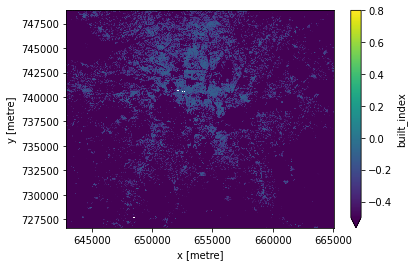

In [22]:
ds_2019_urban_area.built_index.plot(vmin=-0.50, vmax=0.8, cmap='viridis')

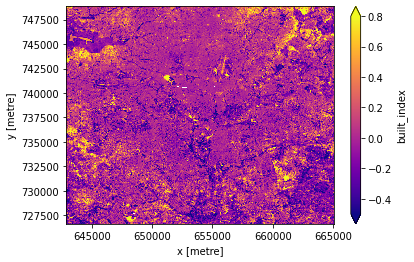

In [23]:
change_urban = ds_2019_urban_area - ds_2014_urban_area
change_urban.built_index.plot(vmin=-0.50, vmax=0.8, cmap='plasma')

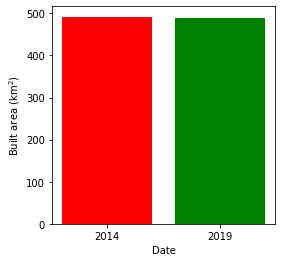

Urbanisation has increased from 2014 to 2019 by 489.69 km2


In [24]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2
builtarea_2014 = ds_2014_urban_area.built_index.count(dim=['x','y']) * area_per_pixel
builtarea_2019 = ds_2019_urban_area.built_index.count(dim=['x','y']) * area_per_pixel

# Plot the resulting area through time
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
plt.bar([0, 1], [builtarea_2014, builtarea_2019], tick_label = [2014, 2019], width = 0.8, color = ['red', 'green'])
axes.set_xlabel("Date")
axes.set_ylabel("Built area (km$^2$)")
plt.show()

change_urban = change_urban.built_index.count(dim=['x','y']) * area_per_pixel
urb = 'decreased'
if change_urban.values > 0:urb = 'increased'
    
print('Urbanisation has {} from {} to {} by {} km2'.format(urb, 2014, 2019, change_urban.values))


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [25]:
print(datacube.__version__)

1.7+262.g1cf3cea8


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)